# **Modelos de Predicción de Seguidores para la cuenta AtravelerTeacher**

### Importar la librerías

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor,export_graphviz, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.feature_selection import mutual_info_regression
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn import tree
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

Leer los datasets

In [2]:
data=pd.read_csv('posts_atravelerteacher.csv')
df_emotions=pd.read_csv("df_emotions_caption_atravelerteacher.csv", usecols=["id","timestamp", "Sentiment_Score"])
df_emotions["Sentiment_Score"].value_counts()

Sentiment_Score
 0.000000    987
 0.100000      9
 0.050000      8
 0.375000      7
-0.100000      6
            ... 
 0.166667      1
 0.100000      1
 0.104167      1
 0.200000      1
 0.113333      1
Name: count, Length: 70, dtype: int64

In [3]:
df_emotions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1129 entries, 0 to 1128
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               1129 non-null   float64
 1   timestamp        1129 non-null   object 
 2   Sentiment_Score  1129 non-null   float64
dtypes: float64(2), object(1)
memory usage: 26.6+ KB


Hacer un Merge de los datasets

In [4]:
data = data.merge(df_emotions[["id", "Sentiment_Score"]], on="id", how="left")

In [5]:
data["Sentiment_Score"] = df_emotions["Sentiment_Score"]


In [ ]:
# Estimado de variables faltantes, se calcula el estimado de seguidores, con el estimado de interacción
# sobre 0.05 de la tasa promedio de interacción
data["total_seguidores"] = 35500
data["total_interac"] = (data["likesCount"] + data["commentsCount"])
data["tasa_interac"] = (data["total_interac"]/data["total_seguidores"]) * 100
# Calcular la media de engagement_rate
avg_engagement_rate = data["tasa_interac"].mean()

data["seguidoresCount_estimado"] = (data["likesCount"] + data["commentsCount"]) / avg_engagement_rate



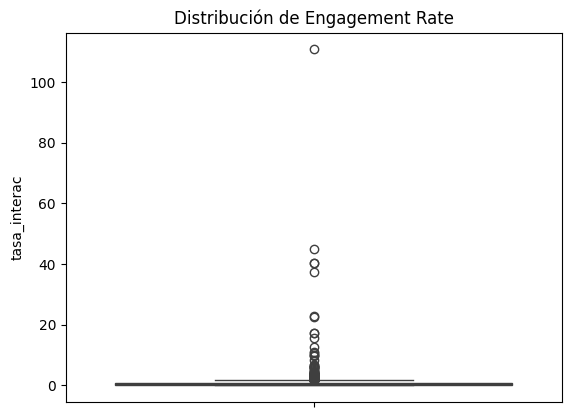

In [8]:
sns.boxplot(data["tasa_interac"])
plt.title("Distribución de Engagement Rate")
plt.show()

In [9]:
Q1 = data["tasa_interac"].quantile(0.25)  # First quartile (25th percentile)
Q3 = data["tasa_interac"].quantile(0.75)  # Third quartile (75th percentile)
IQR = Q3 - Q1  # Interquartile range

# Define lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print("Lower Bound:", lower_bound)
print("Upper Bound:", upper_bound)


Lower Bound: -0.6112676056338028
Upper Bound: 1.6873239436619718


In [10]:
data = data[(data["tasa_interac"] >= lower_bound) & (data["tasa_interac"] <= upper_bound)]

In [11]:
upper_limit = Q3 + 1.5 * IQR
print("Upper Limit for Engagement Rate:", upper_limit)


Upper Limit for Engagement Rate: 1.6873239436619718


In [12]:
upper_limit = data["tasa_interac"].quantile(0.95)
print("95th Percentile Cap for Engagement Rate:", upper_limit)


95th Percentile Cap for Engagement Rate: 1.304225352112676


Reemplazar outlier con la mediana

In [14]:
median_engagement_rate = data["tasa_interac"].median()
data["tasa_interac"] = np.where(
    (data["tasa_interac"] < lower_bound) | (data["tasa_interac"] > upper_bound),
    median_engagement_rate,
    data["tasa_interac"]
)

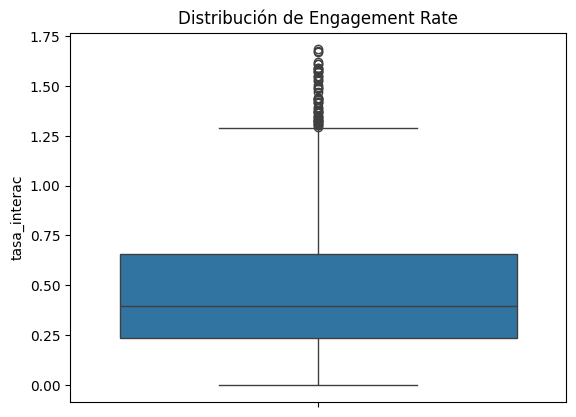

In [15]:
sns.boxplot(data["tasa_interac"])
plt.title("Distribución de Engagement Rate")
plt.show()

In [16]:
print(data[data["tasa_interac"] > 1.0])

               id                                            caption  \
31   3.477347e+18  Escuché esta frase esta semana en una charla q...   
33   3.473906e+18  Reflexionando sobre algo que me sucedió el vie...   
42   3.470296e+18  A veces cuesta y si les soy muy honesta me lo ...   
43   3.466663e+18           Primero personas felices… después profes   
47   3.460172e+18  ¿Conocías esta metodología? ¿Te animas a utili...   
..            ...                                                ...   
958  2.697708e+18  Sabemos que la enseñanza en el contexto actual...   
962  2.680257e+18  Acabo de terminar mi séptima semana enseñando ...   
979  2.675766e+18  Sabemos que la enseñanza en el contexto actual...   
980  2.669316e+18  Hace una semana comenzamos nuestros primer pro...   
998  2.651987e+18  ‍⚖️¿Cómo  establecer las normas de clase al in...   

               timestamp     ownerUsername         locationName     type  \
31   2024-10-12 16:54:29  atravelerteacher  Medellín, Antio

In [17]:
outliers = data[data["tasa_interac"] > 1.0]


Gráfica de la relación entre Video duración y la tasa de interacción

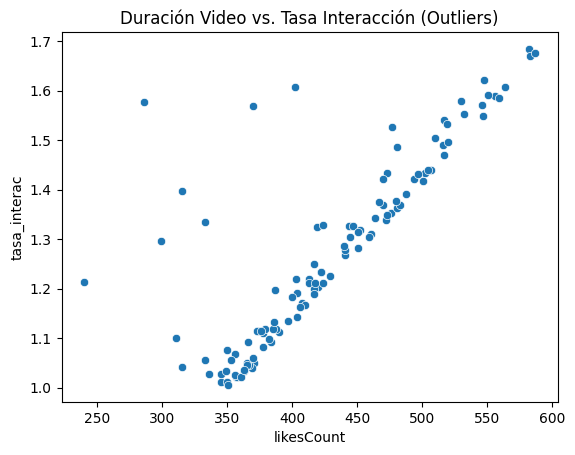

In [18]:
sns.scatterplot(data=outliers, x="likesCount", y="tasa_interac")
plt.title("Duración Video vs. Tasa Interacción (Outliers)")
plt.show()

Conversión de outliers

In [19]:
data["tasa_interac"] = data["tasa_interac"].clip(upper=upper_limit)

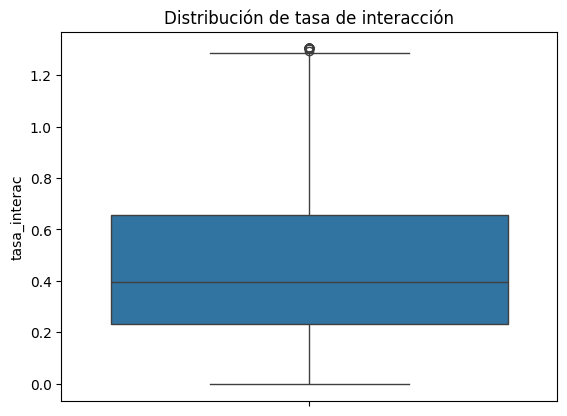

In [20]:
sns.boxplot(data["tasa_interac"])
plt.title("Distribución de tasa de interacción")
plt.show()

Crear columnas calculadas

In [21]:
data["Interaccion_por_videoduracion"] = data["tasa_interac"] / (data["videoDuration"] + 1)

In [22]:
hashtag_columns = [col for col in data.columns if col.startswith("hashtags/")]
data["num_hashtags"] = data[hashtag_columns].apply(lambda row: (row != "-").sum(), axis=1)

# Ensure no missing values in num_hashtags
data["num_hashtags"] = data["num_hashtags"].fillna(0)

In [23]:
data["num_hashtags"].value_counts()

num_hashtags
0     352
23    148
20    116
24     80
22     40
26     39
25     38
18     29
29     25
21     15
6      14
27     13
7      11
4      10
10     10
1      10
5       9
9       8
28      7
8       5
2       5
14      5
11      4
19      3
17      3
13      3
12      3
3       2
15      2
Name: count, dtype: int64

In [24]:
data1=data.drop(['id','caption','ownerUsername','locationName'], axis=1)

In [25]:
data1.dropna(subset=['firstComment'], inplace=True)

In [26]:
data["interaction_per_hashtag"] = data["tasa_interac"] / (data["num_hashtags"] + 1)


In [27]:
# codificación para el campo categórico 'tipo'
encoder = OneHotEncoder()
tipo_cod = encoder.fit_transform(data[["type"]].fillna("Desconocido")).toarray()
tipo_nombres = encoder.get_feature_names_out(["type"])
tipo_cod_df = pd.DataFrame(tipo_cod, columns=tipo_nombres)
data = pd.concat([data.reset_index(drop=True), tipo_cod_df.reset_index(drop=True)], axis=1)

In [28]:
tipo_cod_df

,type_Image,type_Sidecar,type_Video
0,0.0,0.0,1.0
1,0.0,1.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,0.0,1.0,0.0
...,...,...,...
1004,0.0,0.0,1.0
1005,0.0,0.0,1.0
1006,1.0,0.0,0.0
1007,1.0,0.0,0.0


In [29]:

scaler = StandardScaler()
data["Sentiment_Score"] = scaler.fit_transform(data[["Sentiment_Score"]])

In [ ]:
# Selección de columnas
variablesX = ["likesCount", "commentsCount", "videoPlayCount","videoViewCount","interaction_per_hashtag","Interaccion_por_videoduracion","Sentiment_Score"] 
variablesX

['likesCount',
 'commentsCount',
 'videoPlayCount',
 'videoViewCount',
 'interaction_per_hashtag',
 'Interaccion_por_videoduracion',
 'Sentiment_Score']

In [ ]:
# intervalos de confianza

data["seguidoresCount_estimado"][stats.zscore(data["seguidoresCount_estimado"])>2].sort_values(ascending=True)[0:1]

483    397.078493
Name: seguidoresCount_estimado, dtype: float64

In [33]:
X = data[variablesX].fillna(0)
y = data["seguidoresCount_estimado"]

Visualización de varianza
VIF < 5: Low multicollinearity (acceptable).
VIF = 5–10: Moderate multicollinearity (investigate further, may need adjustments).
VIF > 10: High multicollinearity (likely problematic, consider removing or combining variables).

In [34]:
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)


[20.466751298819005, 1.3601599976180603, 12.518047845442318, 25.944459012183422, 1.7601593731707608, 11.004669577910965, 1.004424651649727]


In [35]:
X

,likesCount,commentsCount,videoPlayCount,videoViewCount,interaction_per_hashtag,Interaccion_por_videoduracion,Sentiment_Score
0,111,50,4217,1272,0.453521,0.023280,-0.137813
1,159,4,0,0,0.459155,0.459155,-0.137813
2,305,2,0,0,0.864789,0.864789,-0.137813
3,72,0,0,0,0.202817,0.202817,-0.137813
4,171,4,0,0,0.492958,0.492958,-0.137813
...,...,...,...,...,...,...,...
1004,40,4,0,760,0.004427,0.018779,0.315711
1005,51,5,2698,1138,0.005258,0.005276,1.676284
1006,41,24,0,0,0.183099,0.183099,-0.137813
1007,198,74,0,0,0.766197,0.766197,-0.137813


### Correlación entre columnas a entrenar

In [36]:
correlation_matrix = data[variablesX].corr()

# Display the correlation matrix
print(correlation_matrix)
#print(correlation_matrix["seguidoresCount_estimado"].sort_values(ascending=False))

                               likesCount  commentsCount  videoPlayCount  \
likesCount                       1.000000       0.233958        0.397580   
commentsCount                    0.233958       1.000000        0.137848   
videoPlayCount                   0.397580       0.137848        1.000000   
videoViewCount                   0.419721       0.168469        0.933768   
interaction_per_hashtag          0.347083       0.150457        0.038285   
Interaccion_por_videoduracion    0.530523       0.113674       -0.405139   
Sentiment_Score                  0.015577      -0.017408        0.058059   

                               videoViewCount  interaction_per_hashtag  \
likesCount                           0.419721                 0.347083   
commentsCount                        0.168469                 0.150457   
videoPlayCount                       0.933768                 0.038285   
videoViewCount                       1.000000                -0.022896   
interaction_per_hasht

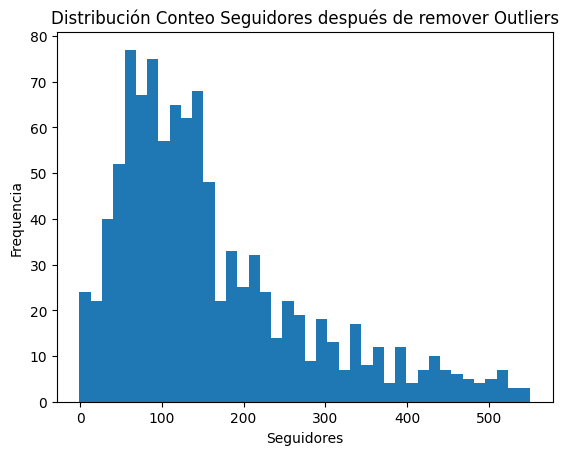

In [37]:
plt.hist(data["seguidoresCount_estimado"], bins=40)
plt.title("Distribución Conteo Seguidores después de remover Outliers")
plt.xlabel("Seguidores")
plt.ylabel("Frequencia")
plt.show()

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
# Filtrar y entrenar con valores positivos
y_train = y_train[y_train > 0]
X_train = X_train.loc[y_train.index]
print(X_train.shape, y_train.shape)
print(y_train.min())


(797, 7) (797,)
0.9212958067645288


In [40]:
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

### Metodos de selección mutual information, permutation para evaluar si las otras columnas añaden valor de predicción

In [41]:
mutual_info = mutual_info_regression(X, y)
feature_importances = pd.Series(mutual_info, index=X.columns).sort_values(ascending=False)
print(feature_importances)

likesCount                       2.871752
interaction_per_hashtag          2.273325
Interaccion_por_videoduracion    1.848227
videoViewCount                   0.483867
videoPlayCount                   0.295219
commentsCount                    0.262573
Sentiment_Score                  0.000000
dtype: float64


### Hyperparameter Tuning:

In [42]:
param_grid = {
    "max_depth": [8, 9, 10],
    "min_samples_leaf": [5, 10, 15],
    "min_samples_split": [10, 20, 30]
}
grid_search = GridSearchCV(DecisionTreeRegressor(random_state=42), param_grid, cv=5, scoring="neg_mean_absolute_error")
grid_search.fit(X_train, y_train)
print("Mejores Parametros:", grid_search.best_params_)

Mejores Parametros: {'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 10}


# **Árbol de Decisión**

In [43]:
# Train Decision Tree
tree_model = DecisionTreeRegressor(
    max_depth=8,
    min_samples_leaf=5,
    min_samples_split=10,
    random_state=42)
tree_model.fit(X_train, y_train)
tree_predicciones = tree_model.predict(X_test)

### Importancia de las columnas Decision Tree

In [44]:
importances = pd.Series(tree_model.feature_importances_, index=X.columns)
print(importances.sort_values(ascending=False))

likesCount                       0.977574
commentsCount                    0.022224
interaction_per_hashtag          0.000081
videoViewCount                   0.000059
videoPlayCount                   0.000046
Interaccion_por_videoduracion    0.000016
Sentiment_Score                  0.000000
dtype: float64


### Evaluación usando Cross-validation

In [45]:
scores = cross_val_score(tree_model, X, y, cv=5, scoring="neg_mean_absolute_error")
print("Cross-Validated MAE:", -scores.mean())


Cross-Validated MAE: 6.306299237429975


In [46]:
train_mae = mean_absolute_error(y_train, tree_model.predict(X_train))
test_mae = mean_absolute_error(y_test, tree_model.predict(X_test))
print(f"Training MAE: {train_mae:.2f}, Test MAE: {test_mae:.2f}")


Training MAE: 4.19, Test MAE: 4.61


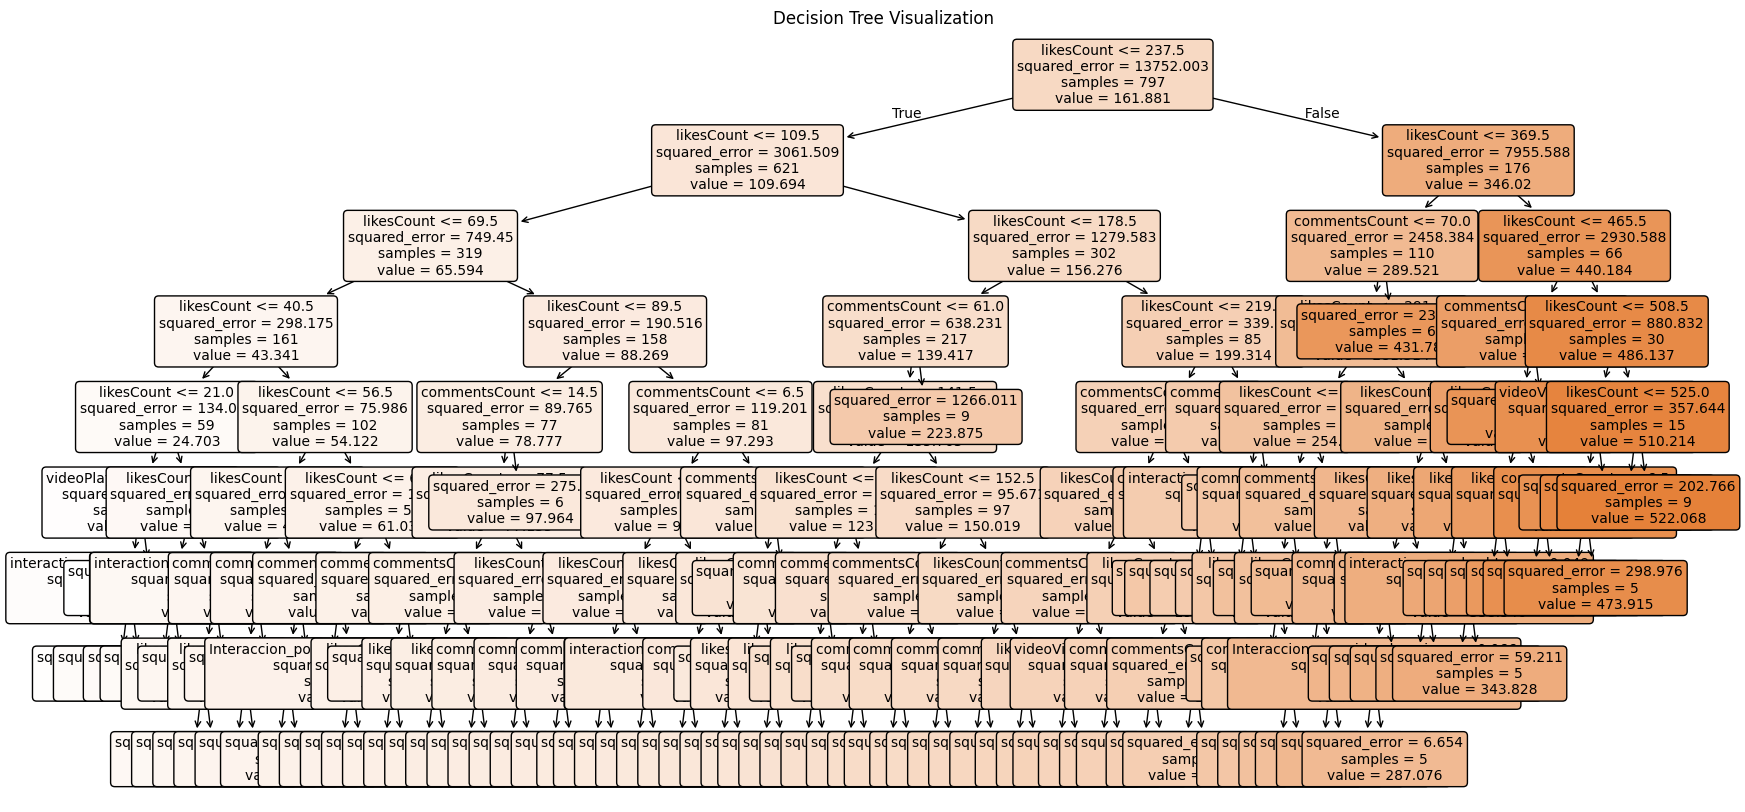

In [ ]:
plt.figure(figsize=(20, 10)) 
plot_tree(
    tree_model,
    feature_names=variablesX, 
    filled=True,            
    rounded=True,          
    fontsize=10             
)
plt.title("Decision Tree Visualization")
plt.show()

# **Random Forest**

In [48]:
# Random Forest
rf_model = RandomForestRegressor(max_depth=10, n_estimators=100, min_samples_leaf=2, min_samples_split=2, random_state=42)
rf_model.fit(X_train, y_train)
rf_predicciones = rf_model.predict(X_test)


### Validación Cruzada

In [49]:
scores = cross_val_score(rf_model, X, y, cv=5, scoring='neg_mean_absolute_error')
print("Cross-Validated MAE:", -scores.mean())


Cross-Validated MAE: 3.7336877713854038


### Curvas de aprendizaje para evaluar el sobreajuste o el subajuste.

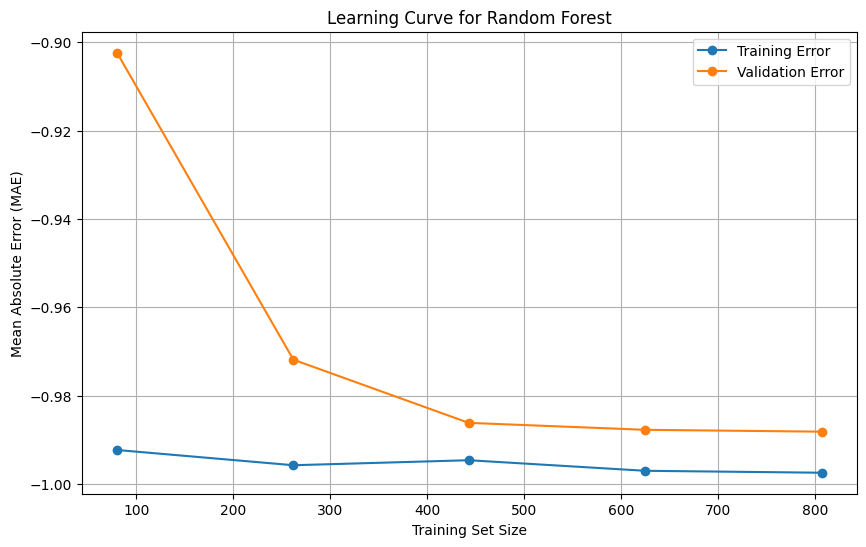

In [50]:
train_sizes, train_scores, test_scores = learning_curve(rf_model, X, y, cv=5)
# Convert scores to positive (MAE)
train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label="Training Error", marker='o')
plt.plot(train_sizes, test_scores_mean, label="Validation Error", marker='o')
plt.title("Learning Curve for Random Forest")
plt.xlabel("Training Set Size")
plt.ylabel("Mean Absolute Error (MAE)")
plt.legend(loc="best")
plt.grid()
plt.show()


### Buscar los mejores parámetros para RandomForest

Mejores Parámetros: {'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}

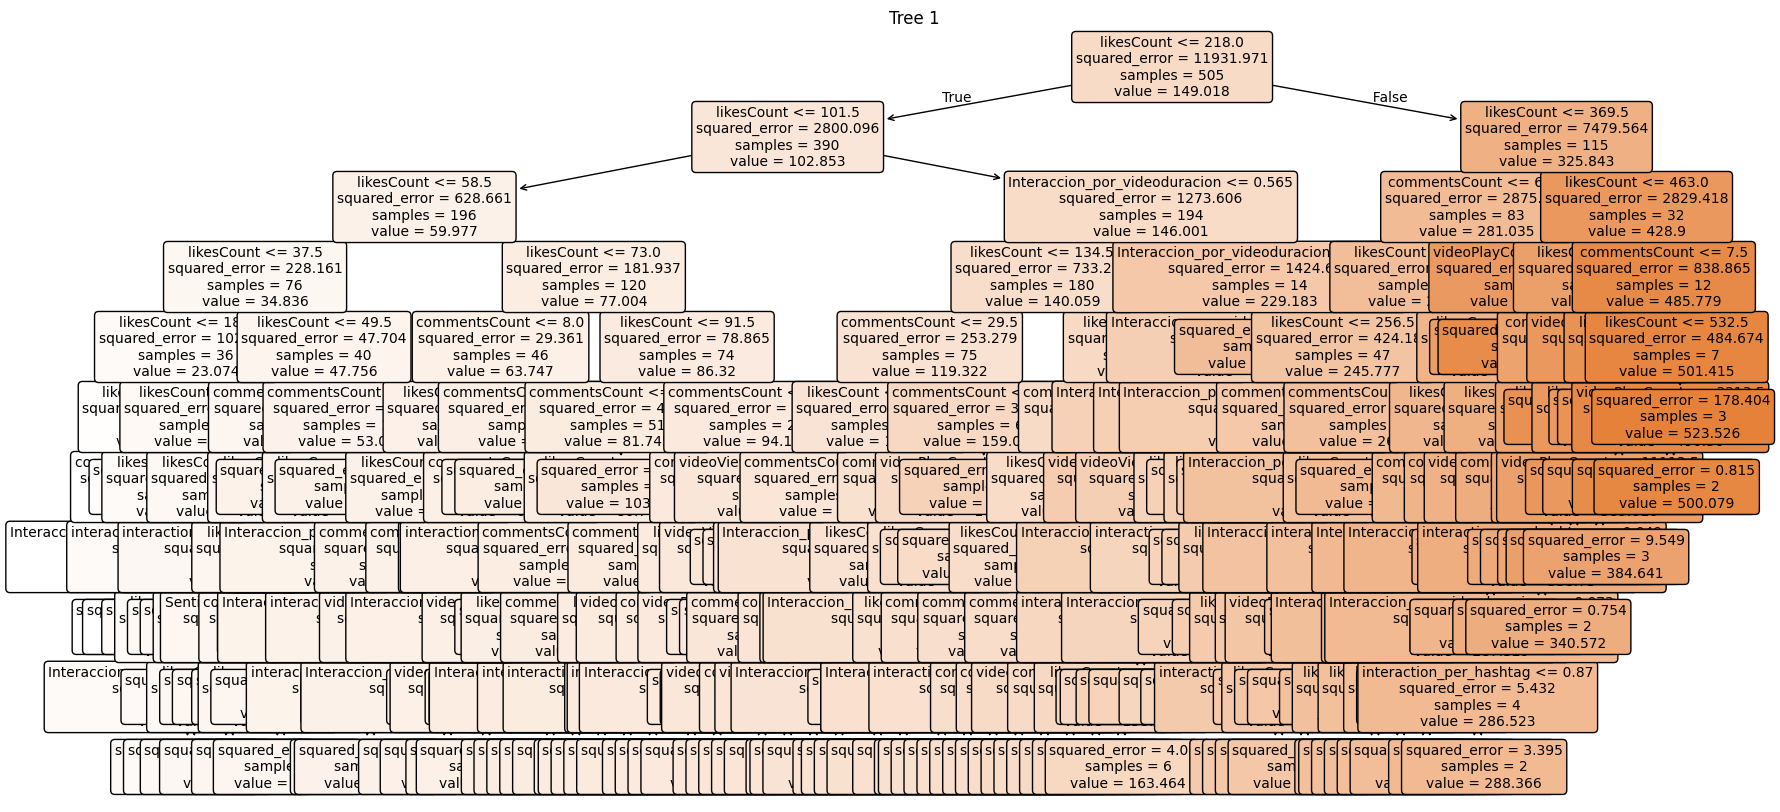

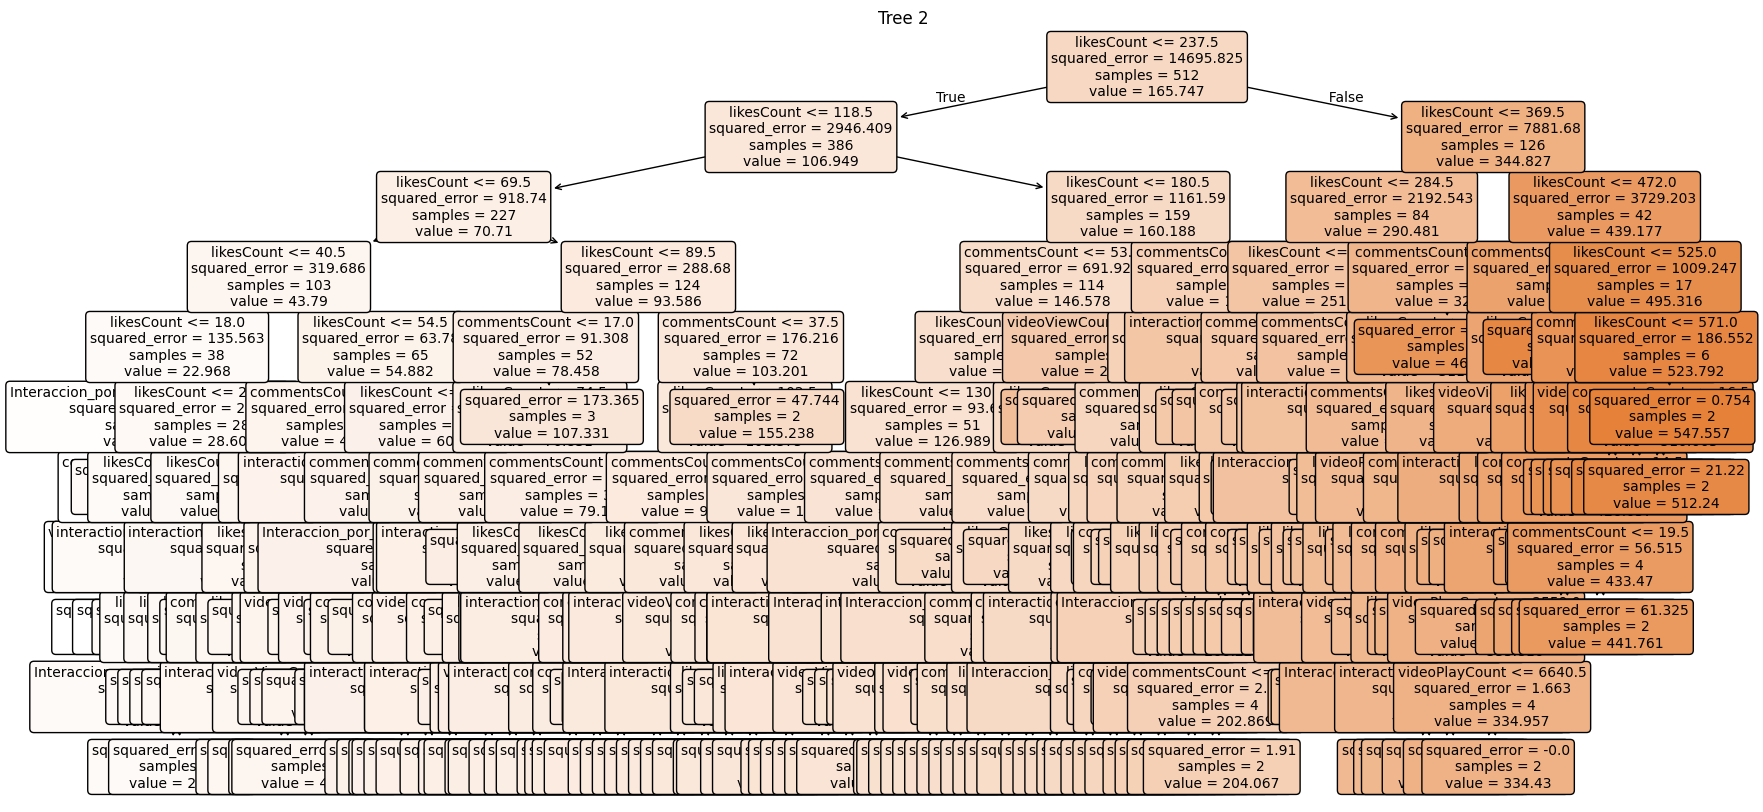

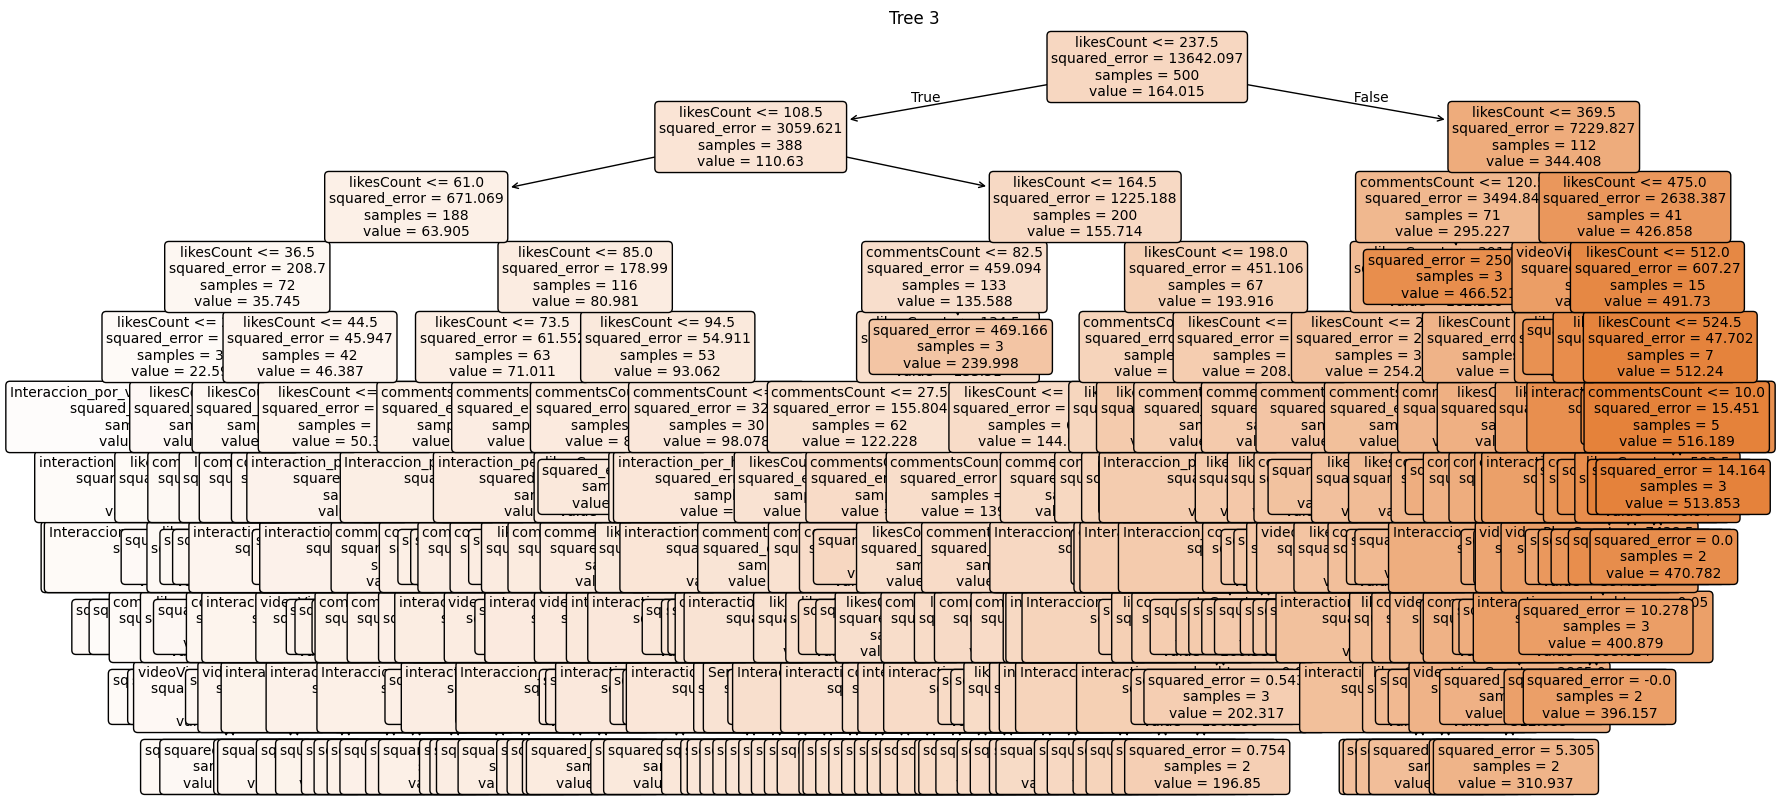

In [52]:
for i, tree in enumerate(rf_model.estimators_[:3]):  # visualiza los primeros 3 árboles
    plt.figure(figsize=(20, 10))
    plot_tree(tree, feature_names=X_train.columns, filled=True, rounded=True, fontsize=10)
    plt.title(f"Tree {i + 1}")
    plt.show()


### Importancia de las columnas en Random Forest

In [53]:
# Feature Importance
importances = pd.Series(rf_model.feature_importances_, index = X.columns)
print(importances.sort_values(ascending=False))

likesCount                       0.977793
commentsCount                    0.019713
Interaccion_por_videoduracion    0.001030
interaction_per_hashtag          0.000860
videoViewCount                   0.000319
videoPlayCount                   0.000281
Sentiment_Score                  0.000004
dtype: float64


# **Modelo XGBoost**

In [54]:
# XGBoost
eval_set = [(X_train, y_train), (X_test, y_test)]
xgb_model = XGBRegressor(
    max_depth=8,               # Maximum tree depth
    n_estimators=100,          # Number of trees
    learning_rate=0.05,         # Learning rate
    random_state=42,
    eval_metric="mae",
    early_stopping_rounds=10 
)
xgb_model.fit(X_train, y_train, eval_set=eval_set, verbose=True)
xgb_predicciones = xgb_model.predict(X_test.to_numpy())

[0]	validation_0-mae:86.43500	validation_1-mae:88.61312
[1]	validation_0-mae:82.23157	validation_1-mae:84.31884
[2]	validation_0-mae:78.23225	validation_1-mae:80.19116
[3]	validation_0-mae:74.44303	validation_1-mae:76.31519
[4]	validation_0-mae:70.83952	validation_1-mae:72.64889
[5]	validation_0-mae:67.41149	validation_1-mae:69.15915
[6]	validation_0-mae:64.15416	validation_1-mae:65.84385
[7]	validation_0-mae:61.05229	validation_1-mae:62.69810
[8]	validation_0-mae:58.10813	validation_1-mae:59.69104
[9]	validation_0-mae:55.29066	validation_1-mae:56.82348
[10]	validation_0-mae:52.61766	validation_1-mae:54.09199
[11]	validation_0-mae:50.06880	validation_1-mae:51.48516
[12]	validation_0-mae:47.64748	validation_1-mae:49.02564
[13]	validation_0-mae:45.34801	validation_1-mae:46.72419
[14]	validation_0-mae:43.15443	validation_1-mae:44.47793
[15]	validation_0-mae:41.07371	validation_1-mae:42.36655
[16]	validation_0-mae:39.10883	validation_1-mae:40.39751
[17]	validation_0-mae:37.24071	validation

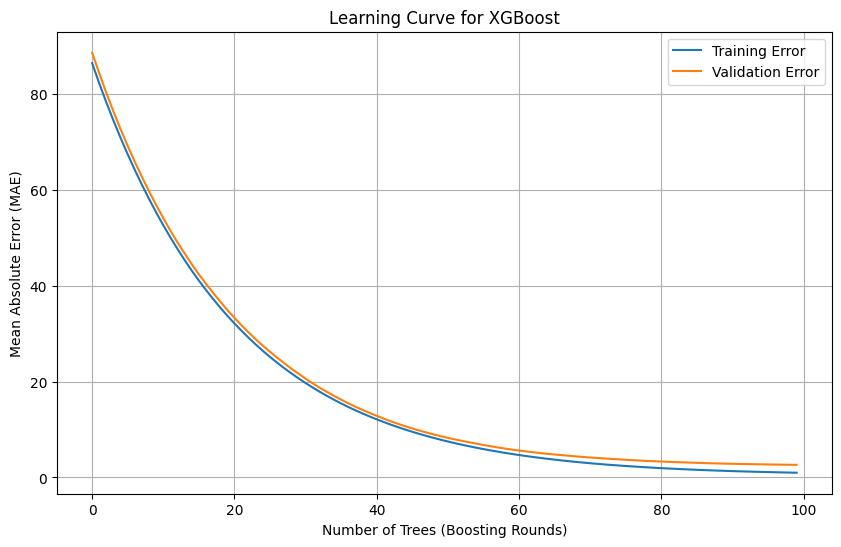

In [55]:

results = xgb_model.evals_result()
epochs = range(len(results["validation_0"]["mae"]))

plt.figure(figsize=(10, 6))
plt.plot(epochs, results["validation_0"]["mae"], label="Training Error")
plt.plot(epochs, results["validation_1"]["mae"], label="Validation Error")
plt.xlabel("Number of Trees (Boosting Rounds)")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("Learning Curve for XGBoost")
plt.legend()
plt.grid()
plt.show()



### Importancia de las columnas en XGBoost

In [56]:
# Importancia de las Columnas
importances = pd.Series(xgb_model.feature_importances_, index=X.columns)
print(importances.sort_values(ascending=False))


likesCount                       0.975851
commentsCount                    0.022533
Interaccion_por_videoduracion    0.000989
interaction_per_hashtag          0.000257
videoPlayCount                   0.000199
videoViewCount                   0.000133
Sentiment_Score                  0.000038
dtype: float32


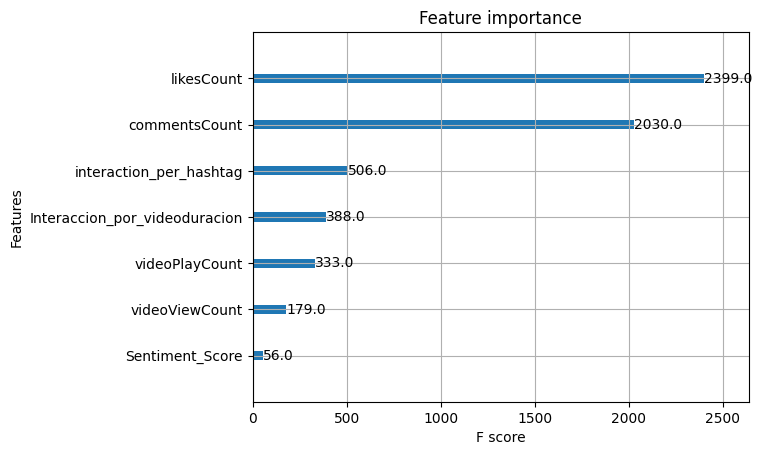

In [57]:
# Plot importance directly
plot_importance(xgb_model, importance_type="weight")  # Options: "weight", "gain", "cover"
plt.show()

### **Evaluación de los módelos**

In [58]:
# Step 4: Evaluación de Modelos
print("Arbol de decisiones MAE:", mean_absolute_error(y_test, tree_predicciones))
print("Random Forest MAE:", mean_absolute_error(y_test, rf_predicciones))
print("XGBoost MAE:", mean_absolute_error(y_test, xgb_predicciones))

Arbol de decisiones MAE: 4.614078792768132
Random Forest MAE: 2.85992639696062
XGBoost MAE: 2.630998194639567


In [59]:
# Step 5: Guardar predicciones
X_test_with_predicciones = X_test.copy()
X_test_with_predicciones["DecisionTree_PredictedFollowers"] = tree_predicciones
X_test_with_predicciones["RandomForest_PredictedFollowers"] = rf_predicciones
X_test_with_predicciones["XGBoost_PredictedFollowers"] = xgb_predicciones

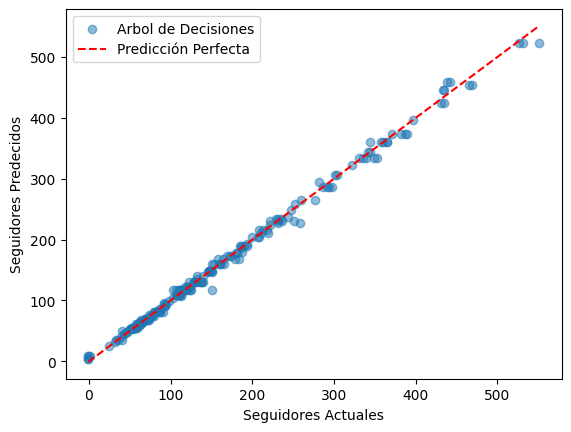

In [60]:

plt.scatter(y_test, X_test_with_predicciones["DecisionTree_PredictedFollowers"], alpha=0.5, label="Arbol de Decisiones")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Predicción Perfecta")
plt.xlabel("Seguidores Actuales")
plt.ylabel("Seguidores Predecidos")
plt.legend()
plt.show()

In [61]:
X_test_with_predicciones["DecisionTree_PredictedFollowers"]

628    453.461796
631     66.333298
741     95.999023
514    359.919562
365     60.805523
          ...    
780     86.049028
334    167.675837
210    122.207179
350     99.346398
78     109.804811
Name: DecisionTree_PredictedFollowers, Length: 202, dtype: float64

In [62]:
X_test_with_predicciones["DecisionTree_PredictedFollowers"].values

array([453.46179609,  66.33329809,  95.99902306, 359.91956184,
        60.80552325,  64.3755445 , 230.45556538,  34.42296151,
        75.17773783, 458.80531177, 159.22394921,  31.86147998,
        58.04163583, 140.5963208 , 172.62780179, 321.90075488,
       445.44652257, 227.56006427, 131.06787698, 122.20717907,
        54.70193853,  67.91266233, 131.06787698,  66.33329809,
       117.66263589,  64.3755445 ,  24.41433888, 117.58643849,
        64.3755445 , 117.66263589, 117.66263589, 159.22394921,
        44.88026716, 445.44652257, 522.06762383,  82.17958596,
       167.67583683,  75.17773783, 230.45556538, 192.73508278,
       117.58643849, 149.19233971, 343.82759508,  60.80552325,
       147.14410171, 159.22394921, 334.43037786, 117.58643849,
       453.46179609, 287.07577339, 372.97125244,  75.17773783,
       117.58643849,  93.85701031, 334.43037786, 122.20717907,
        54.70193853,  64.3755445 ,  75.17773783, 287.07577339,
        48.46015944, 424.92209932,  61.17404157, 185.94

In [63]:
print(X_test_with_predicciones)

     likesCount  commentsCount  videoPlayCount  videoViewCount  \
628         473             36            9817            5316   
631          70              0            2076             997   
741          90             10            1949             794   
514         382              8               0               0   
365          63              0            2151             927   
..          ...            ...             ...             ...   
780          86              8               0            1013   
334         164              8            4836            2571   
210         127              3            3644            1397   
350         106              1               0               0   
78          118              0               0               0   

     interaction_per_hashtag  Interaccion_por_videoduracion  Sentiment_Score  \
628                 0.062106                       0.028623        -0.137813   
631                 0.008216                   

In [64]:
# Evaluate Models
tree_mae = mean_absolute_error(y_test, tree_predicciones)
rf_mae = mean_absolute_error(y_test, rf_predicciones)
xgb_mae = mean_absolute_error(y_test, xgb_predicciones)

tree_r2 = r2_score(y_test, tree_predicciones)
rf_r2 = r2_score(y_test, rf_predicciones)
xgb_r2 = r2_score(y_test, xgb_predicciones)



In [65]:
print(f"DecisionTree - MAE: {tree_mae:.2f}, R²: {tree_r2:.2f}")
print(f"Random Forest - MAE: {rf_mae:.2f}, R²: {rf_r2:.2f}")
print(f"XGBoost - MAE: {xgb_mae:.2f}, R²: {xgb_r2:.2f}")



DecisionTree - MAE: 4.61, R²: 1.00
Random Forest - MAE: 2.86, R²: 1.00
XGBoost - MAE: 2.63, R²: 1.00


In [66]:
# Determinar el mejor Modelo
mae_results = {
    "DecisionTree": tree_mae,
    "Random Forest": rf_mae,
    "XGBoost": xgb_mae
}

r2_results = {
    "Arbol de Decisiones": tree_r2,
    "Random Forest": rf_r2,
    "XGBoost": xgb_r2
}

best_mae_model = min(mae_results, key=mae_results.get)
best_r2_model = max(r2_results, key=r2_results.get)



In [67]:
print(f"\nMejor Modelo por MAE: {best_mae_model} (MAE: {mae_results[best_mae_model]:.2f})")
print(f"Mejor Modelo por R²: {best_r2_model} (R²: {r2_results[best_r2_model]:.2f})")



Mejor Modelo por MAE: XGBoost (MAE: 2.63)
Mejor Modelo por R²: XGBoost (R²: 1.00)


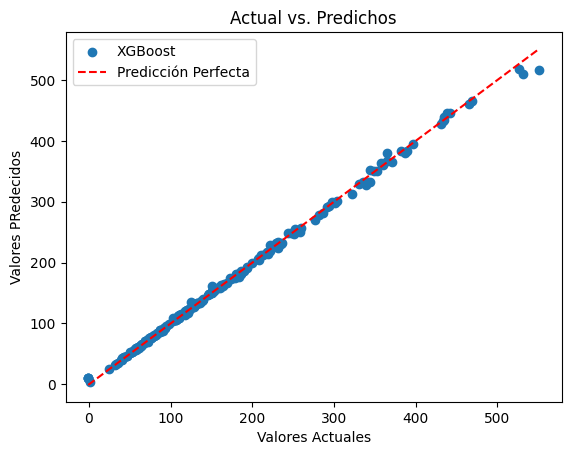

In [68]:
plt.scatter(y_test,X_test_with_predicciones["XGBoost_PredictedFollowers"].values, label="XGBoost")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Predicción Perfecta")
plt.xlabel("Valores Actuales")
plt.ylabel("Valores PRedecidos")
plt.legend()
plt.title("Actual vs. Predichos")
plt.show()


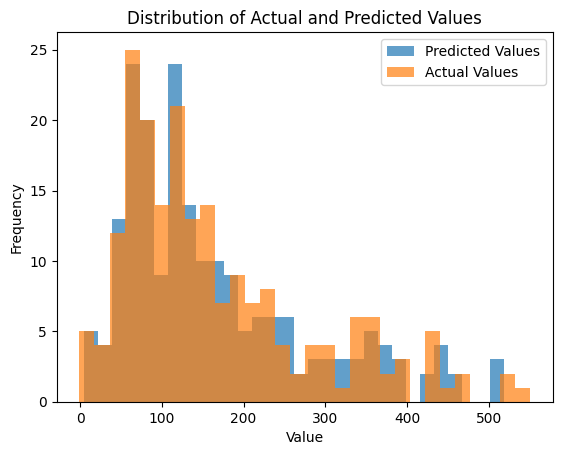

In [69]:
plt.hist(X_test_with_predicciones["XGBoost_PredictedFollowers"].values, bins=30, alpha=0.7, label="Predicted Values")
plt.hist(y_test, bins=30, alpha=0.7, label="Actual Values")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()
plt.title("Distribution of Actual and Predicted Values")
plt.show()


In [70]:
data.to_csv('data_atravelerteacher.csv', index=False)